In [1]:
import pandas as pd
import numpy as np
import string
import re
from functools import reduce
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
import seaborn as sns

[Unsupervised Text Summarization using Sentence Embeddings](https://medium.com/jatana/unsupervised-text-summarization-using-sentence-embeddings-adb15ce83db1)

## Overview:

The summarizer should follow this structure:

```py
def main(text):
    clean_text = clean(text)
    tokenized_text = tokenize(clean_text)
    vector_list = vec_encode(tokenized_text)
    clusters = cluster(vector_list)
    summary = extract_most_meaningful(clusters)
    return summary
```


In [2]:
%run "resources/pretrained-skipthought-encoder/skipthoughts.py"

In [3]:
def init_encoder():
    return Encoder(load_model())
try: # has codec been initialized?
    codec
except NameError:
    codec = init_encoder()

Loading model parameters...
Compiling encoders...
Loading tables...
Packing up...


In [3]:
test = "Is this    a test?\n \t(No, it's only a sample.)\n Testing!,  testing...\n"
#test = "Maria Eliza Rundell (1745 – 16 December 1828) was an English writer. In 1805 when she was over 60, she sent an unedited collection of recipes and household advice to her friend John Murray, of whose family owned a publishing house.\n\nMurray published the work, A New System of Domestic Cookery, in November 1805. It was a huge success and several editions followed; the book sold around half a million copies in Rundell's lifetime. The book was aimed at middle class housewives. In addition to dealing with food preparation, it offers advice on medical remedies and how to set up a home brewery and includes a section entitled \"Directions to Servants\". The book contains an early recipe for tomato sauce—possibly the first—and the first recipe in print for Scotch eggs. Rundell also advises readers on being economical with their food and avoiding waste.\n\nIn 1819 Rundell asked Murray to stop publishing Domestic Cookery, as she was increasingly unhappy with the way the work had declined with each subsequent edition. She wanted to issue a new edition with a new publisher. A court case ensued, and legal wrangling between the two sides continued until 1823, when Rundell accepted Murray's offer of £2,100 for the rights to the work.\n\nRundell wrote a second book, Letters Addressed to Two Absent Daughters, published in 1814. The work contains the advice a mother would give to her daughters on subjects such as death, friendship, how to behave in polite company and the types of books a well-mannered young woman should read. She died in December 1828 while visiting Lausanne, Switzerland."
#test = "HONG KONG — Police fired tear gas against protesters in Hong Kong before meetings Monday between the territory’s leader and Communist Party officials in Beijing, ending a lull in what have become regular clashes between riot squads and demonstrators.\n\nPolice said they fired the choking gas after unrest erupted Sunday night in the Mongkok district of Kowloon.\n\nProtesters threw bricks at officers and tossed traffic cones at a police vehicle, police said. They also set fires, blocked roads and smashed traffic lights with hammers.\n\nVideo footage showed truncheon-wielding riot officers squirting pepper spray at a man in a group of journalists and ganging up to beat and manhandle him.\n\nThe violence and scattered confrontations in shopping malls earlier Sunday, where police also squirted pepper spray and made several arrests, ended what had been a lull of a couple of weeks in clashes between police and protesters.\n\nThe uptick in tension came as Hong Kong leader Carrie Lam was in Beijing on Monday to brief President Xi Jinping on the situation in the semi-autonomous Chinese territory.\n\nHong Kong’s protest movement erupted in June against now-scrapped legislation that would have allowed criminal suspects to be extradited for trial in Communist Party-controlled courts in mainland China.\n\nIt has snowballed into a full-blow challenge to the government and Communist leaders in Beijing, with an array of demands, including that Hong Kong’s leader and legislators all be fully elected."
#test = "President Donald Trump's new trade deal with China will further integrate the world's two largest economies if Beijing honors its commitments in areas ranging from intellectual property protection to agriculture, U.S. Trade Representative Robert Lighthizer said Sunday.\n\n\"Ultimately, whether this whole agreement works is going to be determined by who's making the decisions in China, not in the United States,\" Lighthizer said on CBS News' \"Face the Nation.\" \"If the hardliners are making the decisions, we're going to get one outcome. If the reformers are making the decisions, which is what we hope, then we're going to get another outcome.\"\n\nThe \"phase one\" trade deal announced Friday cancels additional duties that were scheduled to go into effect Sunday, reduces duties on about $120 billion of Chinese goods to 7.5 percent, from 15 percent previously, and leaves a 25 percent duty in place on another $250 billion worth of Chinese goods.\n\nChina, in addition to making promises to better protect U.S. intellectual property, has pledged to buy another $200 billion worth of goods and services from the United States over the next two years, including about $40 billion to $50 billion worth of agricultural products each year.\n\n\"You could think of it as $80 to $100 billion in new sales for agriculture over the course of the next two years. Just massive numbers,\" Lighthizer said.\n\nThat has prompted questions about whether U.S. farmers can actually accommodate the increased demand, without siphoning sales away from other export markets they already have.\n\nFor much of the last two years, there has been a debate about whether Trump's true aim by imposing tariffs on hundreds of billions of dollars of Chinese good was to separate, or \"decouple,\" the U.S. economy from China, rather reach an actual trade agreement.\n\nOn Sunday, Lighthizer indicated the objective was to tie the two economies closer together.\n\n\"The way to think about this deal, is this is a first step in trying to integrate two very different systems to the benefit of both of us,\" the trade chief said.\n\nThe Trump administration also got another trade win last week when House Democrats and the AFL-CIO endorsed a newly revised North American trade agreement with Mexico and Canada, after changes were made to toughen labor enforcement provisions and weaken intellectual property protections for life-saving biologic medicine.\n\nSome of the tweaks made to shore up Democratic support have annoyed Republicans, who have different views of both issues. But that's not expected to block congressional approval. The House is expected to vote on the bill this week and the Senate to follow suit in early 2020, after it finishes Trump's impeachment trial.\n\nLighthizer conceded weakening the biologics provision made the trade deal worse on that point. But he said the overall package was \"better\" as a result of the changes demanded by Democrats.\n\n\"There's nothing about being against labor enforcement that's Republican,\" Lighthizer said. \"The president wants Mexico to enforce its labor laws. He doesn't want American manufacturing workers to have to compete with people who are in very difficult conditions.\""

In [2]:
# get official rouge
%run "resources/rouge-master/rouge/metrics.py"

### clean(text)

`clean(text)` removes newline characters and repeated whitespaces, returning a one-line string with all the text.

In later versions, this function should consider that different texts have different structures.
For example, it should remove signatures from emails, section headers or symbols separating sections of text.


In [4]:
def clean(text):
    return re.sub("\s+", " ", text).strip() #, text.replace(".", ". ").replace(". . . ", "... ")

test2 = clean(test)
print("|" + test2 + "|")

|Is this a test? (No, it's only a sample.) Testing!, testing...|


### tokenize(clean_text)

`tokenize()` splits text and returns a list of sentences using NLTK's pre-trained Punkt Sentence Tokenizer.

In later versions, this tokenizer model should be customised and perfected with PunktSentenceTokenizer(text).
It might also be expanded to handle languages other than English as well.

In [5]:
def tokenize(text):
    sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')
    return sent_detector.tokenize(text.strip())

test3 = tokenize(test2)
print(test3)

['Is this a test?', "(No, it's only a sample.)", 'Testing!, testing...']


### vec_encode(tokenized_text)

`vec_encode(tokenized_text)` uses Skip-Thought Encoder to encode tokenized sentences into NumPy arrays.

For this version, I will use the pre-trained model in the open-source code that the author of the skip-thoughts paper made available. It is a Python 2.7 script that I converted to Python 3.
In future versions, I would train my own model. I would also look into a Quick Thought Vectors solution.

In [8]:
def vec_encode(tokenized_text, encoder):
    return encoder.encode(tokenized_text, verbose=False)

test4 = vec_encode(test3, codec)
print(test4.shape)

(3, 4800)


### cluster(vector_list)

`cluster(vector_list)` uses a KMeans model to cluster the given vectors.

In [9]:
def cluster(vector_list, n_clusters=5):
    n_clusters = abs(n_clusters)
    if n_clusters == 0:   #default: 30% of the sentences of the original text
        n_clusters = np.ceil(vector_list.shape[0]*0.3)
    elif n_clusters<1:
        n_clusters = np.ceil(vector_list.shape[0]*n_clusters)
    elif n_clusters>vector_list.shape[0]:
        n_clusters = vector_list.shape[0]
    
    model = KMeans(n_clusters=int(n_clusters), random_state=0, n_jobs=-1).fit(vector_list)
    return model

test5 = cluster(test4)
print(test5)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)


### extract_most_meaningful(clusters)

`extract_most_meaningful(clusters)` selects and returns the most meaningful sentence in each cluster (i.e. the one closest to the cluster centre). These sentences are ordered according to the averaged sequence order in which they appear in the original text.

In [10]:
def extract_most_meaningful(tokenized_text, vector_list, model):
    extracted = []
    for k in range(model.cluster_centers_.shape[0]):
        index = np.where(model.labels_ == k)[0]
        min_i,_ = pairwise_distances_argmin_min(model.cluster_centers_[k].reshape(1,-1), vector_list)
        p_snt = tokenized_text[int(min_i)]
        extracted.append((np.mean(index), p_snt))

    extracted.sort(key=lambda x: x[0])
    return " ".join([s[1] for s in extracted])

test6 = extract_most_meaningful(test3, test4, test5)
print(test6)

Is this a test? (No, it's only a sample.) Testing!, testing...


In [11]:
print(test)

Is this    a test?
 	(No, it's only a sample.)
 Testing!,  testing...



## SUMMARIZER

Given string `text` and sentence embedding encoder `encoder`, `summarizer` returns a string containing a summary of `text`. If `n_sentences` is defined, the summary will contain either exactly `n` sentences (if the absolute value of `n` is greater than or equal to 1) or `n` percent of the number of sentences in the text (if the absolute value of `n` is a number between 0 and 1. When `n` is 0, 30% of the number of sentences in the text is returned (default behaviour).

Uses `clean(text)`, `tokenize(text)`, `vec_encode(text, encoder)`, `cluster(list)` and `extract_most_meaningful(list, list, model)` functions.

In [12]:
def summarizer(text, encoder, n_sentences=0):
    clean_text = clean(text)
    tokenized_text = tokenize(clean_text)
    vector_list = vec_encode(tokenized_text, encoder)
    model = cluster(vector_list, n_sentences)
    summary = extract_most_meaningful(tokenized_text, vector_list, model)
    return summary

In [13]:
test_summary = summarizer(test, codec, 5)
print(test_summary)

Is this a test? (No, it's only a sample.) Testing!, testing...


## Evaluating summarizer using ROUGE-1 and ROUGE-2

### make_bow(text)

Given string text, `make_bow(text)` removes capitalization, punctuation and splits words into a dictionary with the form `{word:count}`.

Uses `clean(text)` function.

In [6]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words = set(stop_words)

def make_bow(text):
    ttable = str.maketrans("\n", " ", string.punctuation)
    words = clean(text.translate(ttable)).lower().split(" ")
    words = list(set(words) - stop_words - set(['']))
    return {w:words.count(w) for w in words}

print(make_bow(test))

{'test': 1, 'sample': 1, 'testing': 1}


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mjsilva/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### get_rouge_score(text_pred, text_real)

Model evaluation metrics. Given an automatically produced summary text_pred, `get_rouge_score` compares the words in it with the words in a second summary, following ROUGE-1. The function returns a tuple with (precision score, recall score, F2 score).

(Note: the function calculates F2 score to give more weight to recall. The size of the two texts will vary, depending on the summarizer parameters, so the level of conciseness of text_pred is not as relevant.)

Uses `make_bow` function.

In [10]:
def get_rouge_score(text_pred, text_real):
    bow_pred = make_bow(text_pred)
    bow_real = make_bow(text_real)
    
    total_pred_words = reduce(lambda x,y: x+bow_pred[y], bow_pred.keys(), 0)
    total_real_words = reduce(lambda x,y: x+bow_real[y], bow_real.keys(), 0)
    
    if total_pred_words==0:
        total_pred_words=1
    if total_real_words==0:
        total_real_words=1
    
    overlapping_list = [min(bow_pred[k], bow_real[k]) for k in bow_pred.keys() if k in bow_real.keys()]
    overlapping_words = sum(overlapping_list)
    
    precision = overlapping_words/total_pred_words
    recall = overlapping_words/total_real_words
    
    f2_score = 5 * precision * recall / (4 * precision + recall) if (precision!=0 or recall!=0) else 0
    
    return [precision, recall, f2_score]

test_summary=""
print(get_rouge_score(test_summary, test))

[0.0, 0.0, 0]


In [11]:
# ROUGE score using script
def score(pred_text, actual_text):
    pred = [s.split() for s in tokenize(clean(pred_text))]
    text = [s.split() for s in tokenize(clean(actual_text))]
    
    _, _, rouge_1 = rouge_n_summary_level(pred, text, 1)
    _, _, rouge_2 = rouge_n_summary_level(pred, text, 2)
    return rouge_1, rouge_2


### Evaluating using TIPSTER test data

In [17]:
df = pd.read_csv("data/tipster_test_data.csv", index_col=0)
df.head()

,abstract,text
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent..."


In [18]:
df.dropna(axis=0, inplace=True)

In [19]:
df["abstract_size"] = df["abstract"].map(lambda x: len(tokenize(clean(str(x)))))

In [20]:
df["pred_summary"] = df.apply(lambda x: summarizer(x["text"], codec, x["abstract_size"]), axis=1)
df.head()

,abstract,text,abstract_size,pred_summary
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer..."
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...


In [21]:
df.to_csv("data/tipster_with_predicted_summaries.csv")

In [12]:
df = pd.read_csv("data/tipster_with_predicted_summaries.csv", index_col=0)
df.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer...",The left and right context vectors are the bas...
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...,"A CFG is in Greibach normalform (GNF) if, and ..."
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...,The fact that this system includes lexical rul...
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...,Suppose that we are required to compose all th...
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...,"In the following, remember that what we called..."


In [13]:
df["pred_summary_score"] = df.apply(lambda x: score(x["pred_summary"], x["abstract"]), axis=1)
df["my_pred_summary_score"] = df.apply(lambda x: get_rouge_score(x["pred_summary"], x["abstract"]), axis=1)
df.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary,pred_summary_score,my_pred_summary_score
0,This paper presents an algorithm for tagging ...,Since online text becomes available in ever i...,3,"For example, verbs taking bare infinitives wer...",The left and right context vectors are the bas...,"(0.1758241758241758, 0.022471910112359553)","[0.12121212121212122, 0.19047619047619047, 0.1..."
1,The recognition problem for attribute-value g...,Although a universal feature theory does not ...,4,The values of these properties are either atom...,"A CFG is in Greibach normalform (GNF) if, and ...","(0.2368421052631579, 0.013333333333333336)","[0.04, 0.022222222222222223, 0.024390243902439..."
2,Eric Brill introduced transformation-based le...,Text chunking involves dividing sentences int...,5,Bourigault claims that the grammar can parse `...,The fact that this system includes lexical rul...,"(0.23645320197044334, 0.01990049751243781)","[0.09433962264150944, 0.0847457627118644, 0.08..."
3,We propose a paradigm for concurrent natural ...,Parallel and distributed computation is expec...,5,We presuppose that two type variables and are ...,Suppose that we are required to compose all th...,"(0.26865671641791045, 0.030303030303030304)","[0.16129032258064516, 0.10638297872340426, 0.1..."
4,"We propose an algorithm to resolve anaphors, ...","Intrasentential antecedents, i.e., antecedent...",5,The statistics below show that of 262 non-PRR ...,"In the following, remember that what we called...","(0.25333333333333335, 0.05405405405405405)","[0.15, 0.17647058823529413, 0.17045454545454544]"


In [14]:
rouge1 = [a[0] for a in df["pred_summary_score"].values]
rouge2 = [a[1] for a in df["pred_summary_score"].values]

my_precisions = [a[0] for a in df["my_pred_summary_score"].values]
my_recalls = [a[1] for a in df["my_pred_summary_score"].values]
#f2s = [a[2] for a in df["my_pred_summary_score"].values]

x = list(range(len(my_precisions)))

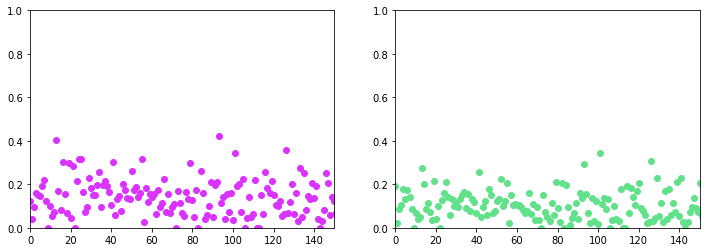

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#axs[0,0].scatter(x, rouge1)
#axs[0,0].set_ylim(0,1)
#axs[0,0].get_xaxis().set_visible(False)
#
#axs[0,1].scatter(x, rouge2)
#axs[0,1].set_ylim(0,1)
#axs[0,1].get_xaxis().set_visible(False)

axs[0].scatter(x, my_precisions, color='#da33ff')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,150)
#axs[0].get_xaxis().set_visible(False)

axs[1].scatter(x, my_recalls, color='#60e18a')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,150)
#axs[1].get_xaxis().set_visible(False)

#sns.regplot(x, my_precisions, scatter=True, ax=axs[1,0])
#sns.regplot(x, my_recalls, scatter=True, ax=axs[1,1])
#sns.regplot(x, f2s, scatter=True, ax=axs[2])

plt.savefig("presentation/ml_tipster.png")
plt.show()

In [38]:
df[["pred_summary_score", "my_pred_summary_score"]].to_csv("data/tipster_ml_scores.csv")

### Evaluating using BBC NEWS test data

In [20]:
df2 = pd.read_csv("data/bbc_test_data.csv", index_col=0)
df2.head()

,abstract,text
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...


In [21]:
df2.dropna(axis=0, inplace=True)

In [22]:
df2["abstract_size"] = df2["abstract"].map(lambda x: len(tokenize(clean(str(x)))))

In [23]:
df2["pred_summary"] = df2.apply(lambda x: summarizer(x["text"], codec, x["abstract_size"]), axis=1)
df2.head()

,abstract,text,abstract_size,pred_summary
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R..."
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...


In [24]:
df2.to_csv("data/bbc_with_predicted_summaries.csv")

In [16]:
df2 = pd.read_csv("data/bbc_with_predicted_summaries.csv", index_col=0)
df2.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree A Christmas t...
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...,Jarre joins fairytale celebration French music...
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...,Musical treatment for Capra film The classic f...
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...,"""It was very hard to follow last year's extrem..."
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...,Poppins musical gets flying start The stage ad...


In [17]:
df2["pred_summary_score"] = df2.apply(lambda x: score(x["pred_summary"], x["abstract"]), axis=1)
df2["my_pred_summary_score"] = df2.apply(lambda x: get_rouge_score(x["pred_summary"], x["abstract"]), axis=1)
df2.head()

,abstract,text,abstract_size,pred_summary,nltk_pred_summary,pred_summary_score,my_pred_summary_score
0,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree\n\nA Christma...,5,"The messages will be ""unwrapped"" by sculptor R...",Gallery unveils interactive tree A Christmas t...,"(0.7830687830687831, 0.7486631016042781)","[0.7391304347826086, 0.7727272727272727, 0.765..."
1,Bloom is to be formally presented with the Han...,Jarre joins fairytale celebration\n\nFrench mu...,6,Jarre joins fairytale celebration French music...,Jarre joins fairytale celebration French music...,"(0.5700934579439253, 0.42452830188679247)","[0.5, 0.5614035087719298, 0.547945205479452]"
2,The classic film It's A Wonderful Life is to b...,Musical treatment for Capra film\n\nThe classi...,4,Frank Capra's 1946 movie starring James Stewar...,Musical treatment for Capra film The classic f...,"(0.6508875739644971, 0.5389221556886228)","[0.5681818181818182, 0.6097560975609756, 0.600..."
3,"""It was very hard to follow last year's extrem...",Richard and Judy choose top books\n\nThe 10 au...,5,Richard and Judy choose top books The 10 autho...,"""It was very hard to follow last year's extrem...","(0.6577777777777778, 0.5919282511210764)","[0.5666666666666667, 0.576271186440678, 0.5743..."
4,Mary Poppins was originally created by author ...,Poppins musical gets flying start\n\nThe stage...,4,Lead actress Laura Michelle Kelly soared over ...,Poppins musical gets flying start The stage ad...,"(0.326797385620915, 0.1986754966887417)","[0.25, 0.2727272727272727, 0.26785714285714285]"


In [18]:
rouge1 = [a[0] for a in df2["pred_summary_score"].values]
rouge2 = [a[1] for a in df2["pred_summary_score"].values]

my_precisions = [a[0] for a in df2["my_pred_summary_score"].values]
my_recalls = [a[1] for a in df2["my_pred_summary_score"].values]
#f2s = [a[2] for a in df2["my_pred_summary_score"].values]

x = list(range(len(my_precisions)))

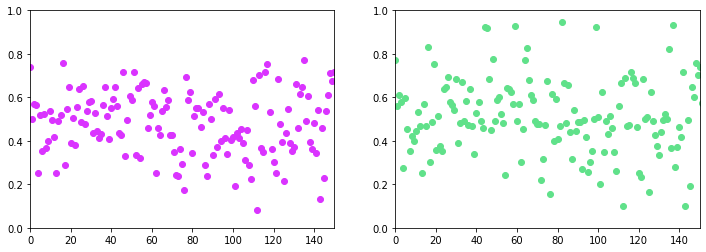

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#axs[0,0].scatter(x, rouge1)
#axs[0,0].set_ylim(0,1)
#axs[0,0].get_xaxis().set_visible(False)
#
#axs[0,1].scatter(x, rouge2)
#axs[0,1].set_ylim(0,1)
#axs[0,1].get_xaxis().set_visible(False)

axs[0].scatter(x, my_precisions, color='#da33ff')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,150)
#axs[0].get_xaxis().set_visible(False)

axs[1].scatter(x, my_recalls, color='#60e18a')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,150)
#axs[1].get_xaxis().set_visible(False)

#sns.regplot(x, my_precisions, scatter=True, ax=axs[1,0])
#sns.regplot(x, my_recalls, scatter=True, ax=axs[1,1])
#sns.regplot(x, f2s, scatter=True, ax=axs[2])

plt.savefig("presentation/ml_bbc.png")
plt.show()

In [43]:
df2[["pred_summary_score", "my_pred_summary_score"]].to_csv("data/bbc_ml_scores.csv")

### Evaluating using NEWS SUMMARY (KAGGLE) test data

In [20]:
df3 = pd.read_csv("data/kaggle_test_data.csv", index_col=0)
df3.head()

,text,abstract
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [21]:
df3.dropna(axis=0, inplace=True)

In [22]:
df3["abstract_size"] = df3["abstract"].map(lambda x: len(tokenize(clean(str(x)))))

In [24]:
df3 = df3.sample(500)

In [25]:
df3["pred_summary"] = df3.apply(lambda x: summarizer(x["text"], codec, x["abstract_size"]), axis=1)
df3.head()

,text,abstract,abstract_size,pred_summary
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...


In [26]:
df3.to_csv("data/kaggle_with_predicted_summaries.csv")

In [20]:
df3 = pd.read_csv("data/kaggle_with_predicted_summaries.csv", index_col=0)
df3.head()

,text,abstract,abstract_size,pred_summary,nltk_pred_summary
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...,India's only existing steam engine was put on ...
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...,"Further, he claimed that the film's title has ..."
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has slammed the se...
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...,Twenty-nine Indian cities and towns including ...
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janmukti Morcha (GJM) has given the...


In [21]:
df3["pred_summary_score"] = df3.apply(lambda x: score(x["pred_summary"], x["abstract"]), axis=1)
df3["my_pred_summary_score"] = df3.apply(lambda x: get_rouge_score(x["pred_summary"], x["abstract"]), axis=1)
df3.head()

,text,abstract,abstract_size,pred_summary,nltk_pred_summary,pred_summary_score,my_pred_summary_score
3344,India's only existing steam engine was put on ...,"A shiny, sleek white steam engine huffing and ...",16,India's only existing steam engine was put on ...,India's only existing steam engine was put on ...,"(0.23631123919308358, 0.10434782608695653)","[0.6, 0.13846153846153847, 0.16363636363636366]"
3080,A producer filed a petition claiming the title...,A court on Thursday sought the response of sup...,25,A producer filed a petition claiming the title...,"Further, he claimed that the film's title has ...","(0.15280135823429541, 0.06473594548551959)","[0.8, 0.12121212121212122, 0.145985401459854]"
858,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has expressed his ...,47,Television actor Karan Wahi has slammed the se...,Television actor Karan Wahi has slammed the se...,"(0.11457036114570361, 0.0749063670411985)","[0.8125, 0.10569105691056911, 0.12795275590551..."
227,Twenty-nine Indian cities and towns including ...,"Twenty-nine Indian cities and towns, including...",22,Twenty-nine Indian cities and towns including ...,Twenty-nine Indian cities and towns including ...,"(0.20253164556962025, 0.1016949152542373)","[0.9696969696969697, 0.1711229946524064, 0.204..."
177,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janamukti Morcha has given a ten-da...,14,The Gorkha Janmukti Morcha (GJM) has given the...,The Gorkha Janmukti Morcha (GJM) has given the...,"(0.27956989247311825, 0.1732851985559567)","[0.7, 0.20388349514563106, 0.23755656108597287]"


In [22]:
rouge1_2 = [a[0] for a in df3["pred_summary_score"].values]
rouge2_2 = [a[1] for a in df3["pred_summary_score"].values]

my_precisions_2 = [a[0] for a in df3["my_pred_summary_score"].values]
my_recalls_2 = [a[1] for a in df3["my_pred_summary_score"].values]
#f2s = [a[2] for a in df3["my_pred_summary_score"].values]

x2 = list(range(len(my_precisions_2)))

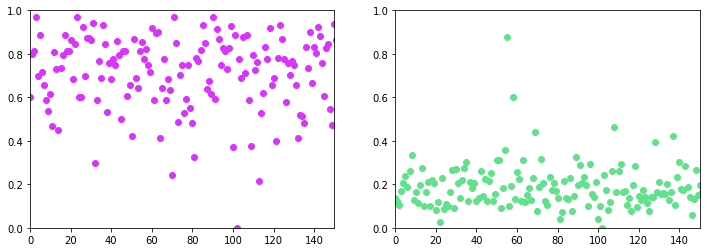

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

#sns.regplot(x2, rouge1_2, scatter=True, ax=axs[0,0])
#sns.regplot(x2, rouge2_2, scatter=True, ax=axs[0,1])

axs[0].scatter(x2, my_precisions_2, color='#da33ff')
axs[0].set_ylim(0,1)
axs[0].set_xlim(0,150)
#axs[0].get_xaxis().set_visible(False)

axs[1].scatter(x2, my_recalls_2, color='#60e18a')
axs[1].set_ylim(0,1)
axs[1].set_xlim(0,150)
#axs[1].get_xaxis().set_visible(False)

#sns.regplot(x2, my_precisions_2, scatter=True, ax=axs[1,0])
#sns.regplot(x2, my_recalls_2, scatter=True, ax=axs[1,1])
#sns.regplot(x2, f2s, scatter=True, ax=axs[2])

plt.savefig("presentation/ml_kaggle.png")
plt.show()

In [50]:
df3[["pred_summary_score", "my_pred_summary_score"]].to_csv("data/kaggle_ml_scores.csv")